# Extended CoCo

## THE CODE

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def parse_nucleotides(sequence):
    new_seq = []
    map_to_vals = {"a": 1, "c": 2, "g": 3, "t":4}
    for symbol in sequence:
        new_seq.append(map_to_vals[symbol])
        
    return new_seq

In [4]:
def getskmer(snippet, profile):
    spaced_kmer = snippet * profile
    spaced_kmer = spaced_kmer[spaced_kmer != 0]
    s = ''.join(str(x) for x in spaced_kmer)
    return s

In [5]:
def fixed_maxcount(pos, seqs, seqs_kmers, spaced_kmer_profile, seq_to_investigate=0):
    target = seqs[seq_to_investigate]
    f = len(spaced_kmer_profile)
    counts_i = []
    indexes = []
    len_loop = min(f-1, pos)
    start = pos-len_loop
    end = pos+1
    for i in range(start, end):
        if spaced_kmer_profile[pos-i] != 1:
            counts_i.append(0)
            indexes.append(-1)
            continue
            
        # Extract k mers starting at selected position
        spaced_kmer = target[i : i+f] * spaced_kmer_profile
        spaced_kmer = spaced_kmer[spaced_kmer != 0]
        s = ''.join(str(x) for x in spaced_kmer)
        counts_i.append(seqs_kmers[s]) 
        indexes.append(i)
    
    return max(counts_i), indexes[np.argmax(counts_i)]

In [181]:
#
# CORRECT COUNTS - AN ATTEMPT AT FIXING THE ECLIPSE ERROR
#
def correct_counts_robustly(maxed_counts, maxed_count_indices, target_sequence, start_end_posis, seqs, diff_profile, kmer_profile):
    f = len(kmer_profile)
    correction_artifact = []
    last_correction = 0 
    # When corrections are necessary they are written into the maxed_counts array
    for i in range(1,len(maxed_count_indices)):
        # Make sure we have a change position on our hands.
        if maxed_counts[i] != maxed_counts[i-1]: 
            # Correct for reads that start in between the two maxed_count indices:
            #start_sum_at = max(i-f,0)
            #start_sum_at = max(0, maxed_count_indices[i-1]-f+1)
            '''
            start_sum_at = maxed_count_indices[i-1]
            end_sum_at = maxed_count_indices[i]+1
            if start_sum_at <= end_sum_at:
                correction = sum(start_end_posis[start_sum_at:end_sum_at])
            else:
                correction = -sum(start_end_posis[end_sum_at:start_sum_at])
            diff_profile[i-1] += correction
            correction_artifact.append([correction, (start_sum_at, end_sum_at), start_end_posis[start_sum_at:end_sum_at]])
            '''
            start_sum_at = last_correction
            end_sum_at = maxed_count_indices[i]+1
            #end_sum_at = i+1
            
            if start_sum_at <= end_sum_at:
                correction = sum(start_end_posis[start_sum_at:end_sum_at])
            else:
                correction = -sum(start_end_posis[end_sum_at:start_sum_at])
                
            # This if clause tries to prevent the eclipse
            # The important part of this is that the last_correction is not updated if we have a SNP or seqerr
            #if diff_profile[i-1] + correction == 0: # If not we have a SNP or seq error
            last_correction = maxed_count_indices[i] + 1
            diff_profile[i-1] += correction
            correction_artifact.append([correction, (start_sum_at, end_sum_at), start_end_posis[start_sum_at:end_sum_at]])
            
            #else:
                #print("ABORTED:")
                #print(end_sum_at)
                #print(start_end_posis[start_sum_at:end_sum_at])
    return diff_profile, correction_artifact

In [182]:
def get_correction_profile_robustly(target, seqs, overlap_size):
    corr_profile = [0 for i in range(len(target)-overlap_size)]
    #corr_profile[0] = -1
    for i in range(len(target)-overlap_size):
        #
        #if i == 0:
            # Note that this whole check is necessary because our target sequence, i.e. the read we are investigating at the moment
            # also starts at the beginning and would thus be added to the count profile. We anticipate this by increasing the correction
            # profile at this point to one s.t. the loop below can reduce it to zero in the first step if just our sequence starts there.
            # If another sequence starts here, then the loop below will reduce the correction profile below zero
            #corr_profile[0] = 1
        for seq in seqs:
            if (target[i : i+overlap_size] == seq[0 : overlap_size]).all(): # starts
                corr_profile[i] -= 1
            elif (target[i : i+overlap_size] == seq[len(seq)-overlap_size : len(seq)]).all(): # ends
                corr_profile[i] += 1
    corr_profile[0]=0
    return corr_profile

In [183]:
def get_correction_profile_robustly_v2(target, seqs, overlap_size, profile):
    corr_profile = [0 for i in range(len(target)-overlap_size)]
    for i in range(len(target)-overlap_size):
        #
        #if i == 0:
            # Note that this whole check is necessary because our target sequence, i.e. the read we are investigating at the moment
            # also starts at the beginning and would thus be added to the count profile. We anticipate this by increasing the correction
            # profile at this point to one s.t. the loop below can reduce it to zero in the first step if just our sequence starts there.
            # If another sequence starts here, then the loop below will reduce the correction profile below zero
            #corr_profile[0] = 1
        for seq in seqs:
            target_skmer = getskmer(target[i : i+overlap_size], profile)
            if (target_skmer == getskmer(seq[0 : overlap_size], profile)): # starts
                corr_profile[i] -= 1
            elif (target_skmer == getskmer(seq[len(seq)-overlap_size : len(seq)], profile)): # ends
                corr_profile[i] += 1
    #corr_profile[0]=0
    return corr_profile

In [184]:
def correct_robustly(filename, str_profile, seq_to_investigate):
    seqs = []
    with open(filename) as file_in:
        for line in file_in:
            newline = line.rstrip('\n')
            sequence_chars = [char for char in newline]
            sequence = parse_nucleotides(sequence_chars)
            seqs.append(np.array(sequence))
    
    profile = [int(character) for character in str_profile]
    k = sum(profile)
    f = len(profile)
    
    # Turn into np arrays for componentwise multiplication
    profile = np.array(profile)
    
    # Count occurence of spaced k-mers
    seqs_kmers = {}
    for sequence in seqs:
        for i in range(len(sequence) - f):
            spaced_kmer = sequence[i:i+f] * profile
            spaced_kmer = spaced_kmer[spaced_kmer != 0]
            s = ''.join(str(x) for x in spaced_kmer)
            if s not in seqs_kmers:
                seqs_kmers[s] = 1
            else:
                seqs_kmers[s] += 1
    
    # Get maxcounts from counts
    target = seqs[seq_to_investigate]
    xpoints = np.array([i for i in range(len(target) - f)])
    max_counts = []
    max_count_indices = []
    for i in range(len(xpoints)):
        maxp, argmaxp = fixed_maxcount(i, seqs, seqs_kmers, profile, seq_to_investigate=seq_to_investigate)
        max_counts.append(maxp)
        max_count_indices.append(argmaxp)
    #print(max_count_indices)
    # Get correction profile:
    start_end_posis = get_correction_profile_robustly(target, seqs, f)
    #print(start_end_posis)
    #print(max_count_indices)
    
    # Get diff profile:
    pre_corr_diff_profile = [max_counts[j] - max_counts[j-1] for j in range(1,len(max_counts))]
    
    # Apply correction strategy
    ypoints, correction_artifact = correct_counts_robustly(max_counts, max_count_indices, target, start_end_posis, seqs, pre_corr_diff_profile.copy(), profile)
    return xpoints[1:], ypoints, max_counts, start_end_posis, pre_corr_diff_profile, correction_artifact, max_count_indices


# Tests

## Simple Test

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[[1, (0, 38), [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]], [1, (38, 96), [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]], [1, (96, 138), [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

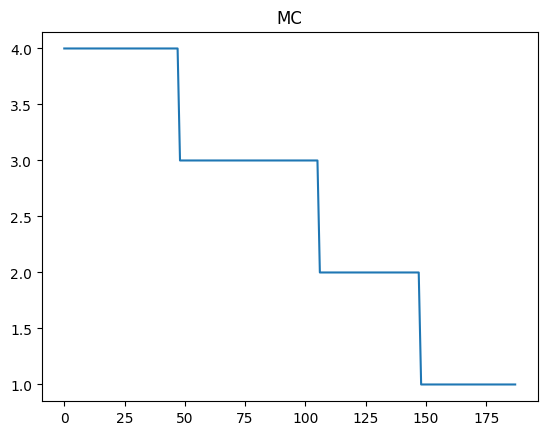

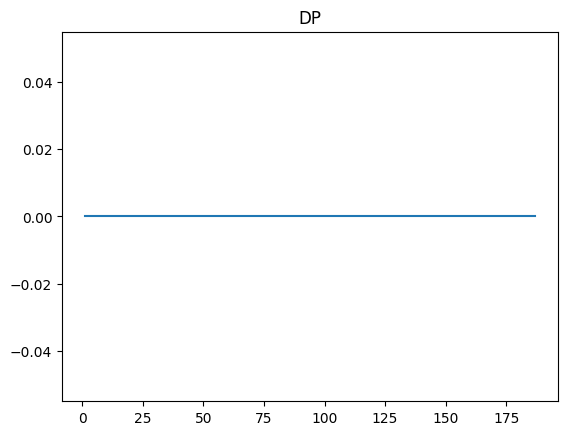

In [185]:
xpoints, ypoints, mc, se, diff_p, artifact, mci = correct_robustly("data/simplest.txt", "111110101101", 3)
print(se)
print(artifact)
print(mci)
# Plot
plt.title("MC")
plt.plot([i for i in range(len(mc))], mc)
plt.show()
# Plot
plt.title("DP")
plt.plot(xpoints, ypoints)
plt.show()

## Test 2

### What if the SNP is in the beginning? SOLID VS SPACED

[0, 0, 0, 0, 1, 0, 0, 7, 7, 7, 7, 8, 7, 7, 7, 7, 7, 7, 8, 7, 7, 8, 7, 7, 7, 8, 7, 8, 7, 8, 7, 7, 7, 8, 7, 7, 8, 7, 7, 7, 7, 7, 7, 8, 7, 7, 7, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 66, 66, 66, 66, 70, 70, 72, 72, 72, 72, 73, 72, 72, 72, 72, 72, 72, 83, 83, 83, 83, 84, 83, 83, 83, 83, 83, 83, 84, 83, 83, 84, 83, 83, 83, 101, 101, 101, 101, 102, 101, 101, 101]
[[-1, (0, 8), [0, 0, 0, 0, 0, 0, 0, -1]], [-1, (8, 67), [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0, 0, 0, 0, -1]], [-1, (67, 71), [0, 0, 0, -1]], [-1, (71, 73), [0, -1]], [-1, (73, 84), [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]], [-1, (84, 102), [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]]]
[0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0,

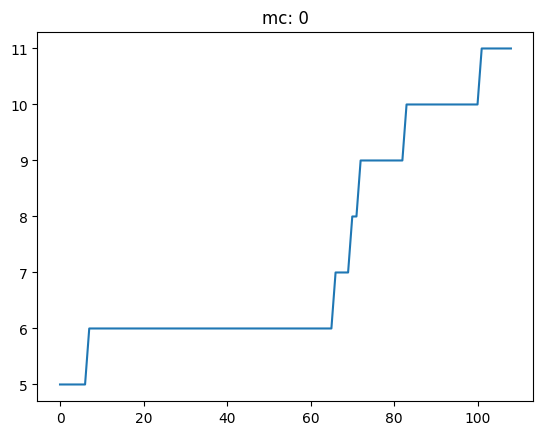

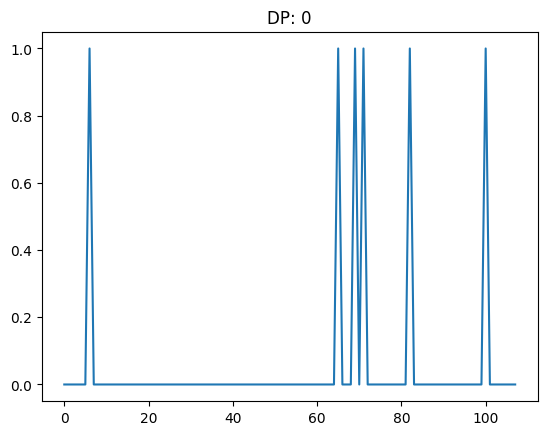

[6, 65, 69, 71, 82, 100]


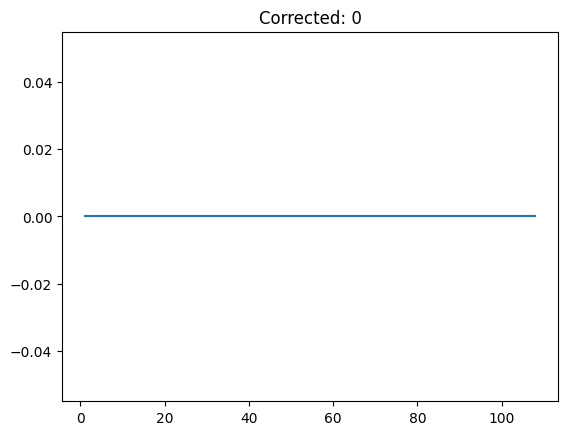

[]


In [186]:
with open("data/output.txt") as file_in:
    seqs = []
    for line in file_in:
        newline = line.rstrip('\n')
        sequence_chars = [char for char in newline]
        #sequence = parse_nucleotides(sequence_chars)
        seqs.append(sequence_chars)

for i in range(len(seqs)):
    # Execute the function we created above on the circular synthetic data.
    # 11110111111011011101010111011011111101111
    # 11111111111101011101010111011011111101111
    # 111111111111111111111111111111111
    # 111111111111101111111111111111111
    xpoints, ypoints, maxcounts, se, pc_diff_profile, artifact, mci = correct_robustly("data/output_bsp.txt", "11110111111011011101010111011011111101111", i)
    #if not (np.array(ypoints) == np.array([0 for i in range(len(ypoints))])).all():
    print(mci)
    print(artifact)
    print(se)
    # Max Counts
    plt.title("mc: "+str(i))
    plt.plot([i for i in range(len(maxcounts))], maxcounts)
    plt.show()
    # DP
    plt.title("DP: "+str(i))
    plt.plot([i for i in range(len(pc_diff_profile))], pc_diff_profile)
    plt.show()
    print([i for i in range(len(pc_diff_profile)) if pc_diff_profile[i]!=0])
    # Corrected DP
    plt.title("Corrected: "+str(i))
    plt.plot(xpoints, ypoints)
    plt.show()
    print([i for i in range(len(ypoints)) if ypoints[i]!=0])
    break

#### Now we introduce a SNP

[0, 1, 1, 1, 1, 5, 1, 1, 8, 8, 8, 8, 5, 8, 8, 8, 8, 8, 8, 0, 8, 8, 15, 8, 8, 8, 20, 8, 15, 8, 15, 8, 8, 8, 15, 8, 8, 20, 8, 8, 8, 8, 8, 8, 20, 8, 8, 8, 8, 15, 15, 20, 15, 15, 15, 15, 21, 20, 20, 20, 20, 21, 22, 23, 24, 25, 66, 66, 66, 66, 70, 70, 72, 72, 72, 72, 73, 72, 72, 72, 72, 72, 72, 83, 83, 83, 83, 84, 83, 83, 83, 83, 83, 83, 84, 83, 83, 84, 83, 83, 83, 101, 101, 101, 101, 102, 101, 101, 101]
[[0, (0, 2), [0, 0]], [0, (2, 9), [0, 0, 0, 0, 0, 0, 0]], [0, (9, 6), []], [0, (6, 9), [0, 0, 0]], [0, (9, 1), []], [0, (1, 9), [0, 0, 0, 0, 0, 0, 0, 0]], [-1, (9, 67), [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0, 0, 0, 0, -1]], [-1, (67, 71), [0, 0, 0, -1]], [-1, (71, 73), [0, -1]], [-1, (73, 84), [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]], [-1, (84, 102), [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]]]
[(45, 1), (59, -1), (66, -1), (70, -1), (72, -1), (83, -1), (101, -

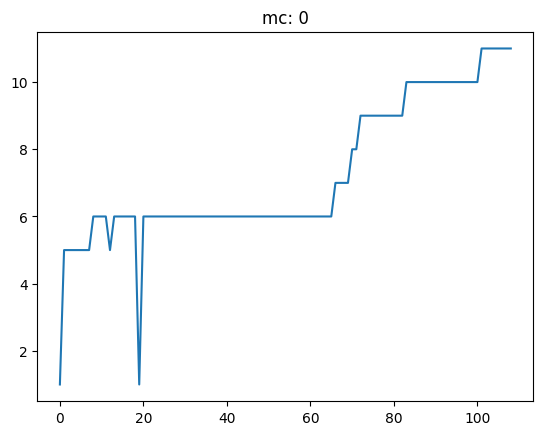

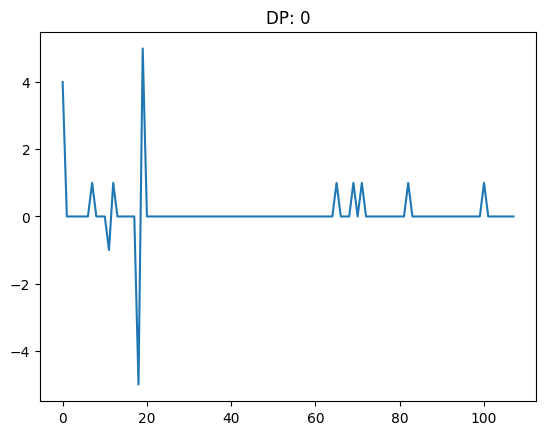

[0, 7, 11, 12, 18, 19, 65, 69, 71, 82, 100]


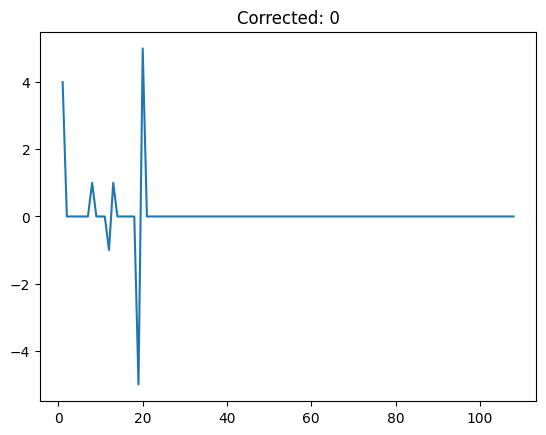

[0, 7, 11, 12, 18, 19]


In [187]:
with open("data/manipulated_output_bsp.txt") as file_in:
    seqs = []
    for line in file_in:
        newline = line.rstrip('\n')
        sequence_chars = [char for char in newline]
        #sequence = parse_nucleotides(sequence_chars)
        seqs.append(sequence_chars)

for i in range(len(seqs)):
    # Execute the function we created above on the circular synthetic data.
    # 11110111111011011101010111011011111101111
    # 11111111111101011101010111011011111101111
    # 111111111111111111111111111111111
    # 111111111111101111111111111111111
    xpoints, ypoints, maxcounts, se, pc_diff_profile, artifact, mci = correct_robustly("data/manipulated_output_bsp.txt", "11110111111011011101010111011011111101111", i)
    if not (np.array(ypoints) == np.array([0 for i in range(len(ypoints))])).all():
        print(mci)
        print(artifact)
        print([(i, se[i]) for i in range(len(se)) if se[i]!=0])
        # Max Counts
        plt.title("mc: "+str(i))
        plt.plot([i for i in range(len(maxcounts))], maxcounts)
        plt.show()
        # DP
        plt.title("DP: "+str(i))
        plt.plot([i for i in range(len(pc_diff_profile))], pc_diff_profile)
        plt.show()
        print([i for i in range(len(pc_diff_profile)) if pc_diff_profile[i]!=0])
        # Corrected DP
        plt.title("Corrected: "+str(i))
        plt.plot(xpoints, ypoints)
        plt.show()
        print([i for i in range(len(ypoints)) if ypoints[i]!=0])
        break

#### Now observe how the solid k-mer does:
All of the k-mers in the beginning have to overlap the SNP and therefore have a maxcount of 0. Then, at the SNP we have a big jump because the k-mers can avoid the SNP.

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 21, 22, 23, 24, 25, 26, 27, 28, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 70, 70, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 94, 94, 94, 94, 94, 94, 94, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101]
[[0, (0, 21), [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], [-1, (21, 60), [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, -1, 0, 0, -1]], [-1, (60, 71), [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]], [-1, (71, 73), [0, -1]], [-1, (73, 84), [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]], [-1, (84, 95), [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]], [-1, (95, 102), [0, 0, 0, 0, 0, 0, -1]]]
[(55, 1), (56, -1), (59, -1), (70, -1), (72, -1), (83, -1), (94, -1), (101, -1), (104,

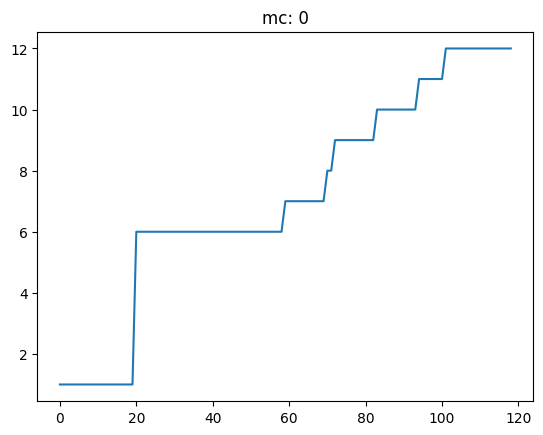

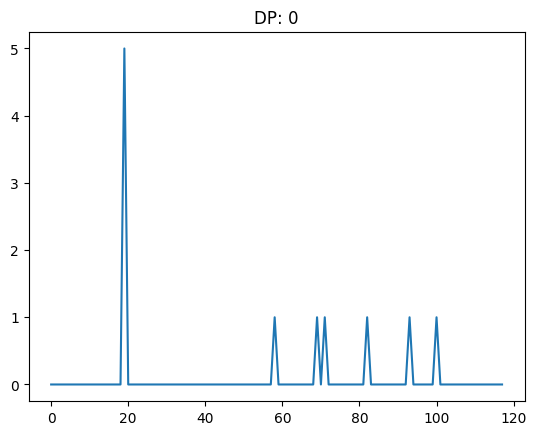

[19, 58, 69, 71, 82, 93, 100]


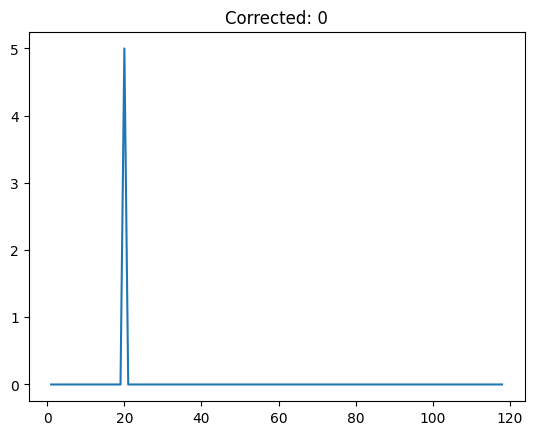

[19]


In [188]:
with open("data/manipulated_output_bsp.txt") as file_in:
    seqs = []
    for line in file_in:
        newline = line.rstrip('\n')
        sequence_chars = [char for char in newline]
        #sequence = parse_nucleotides(sequence_chars)
        seqs.append(sequence_chars)

for i in range(len(seqs)):
    # Execute the function we created above on the circular synthetic data.
    # 11110111111011011101010111011011111101111
    # 11111111111101011101010111011011111101111
    # 111111111111111111111111111111111
    # 111111111111101111111111111111111
    xpoints, ypoints, maxcounts, se, pc_diff_profile, artifact, mci = correct_robustly("data/manipulated_output_bsp.txt", "1111111111111111111111111111111", i)
    if not (np.array(ypoints) == np.array([0 for i in range(len(ypoints))])).all():
        print(mci)
        print(artifact)
        print([(i, se[i]) for i in range(len(se)) if se[i]!=0])
        # Max Counts
        plt.title("mc: "+str(i))
        plt.plot([i for i in range(len(maxcounts))], maxcounts)
        plt.show()
        # DP
        plt.title("DP: "+str(i))
        plt.plot([i for i in range(len(pc_diff_profile))], pc_diff_profile)
        plt.show()
        print([i for i in range(len(pc_diff_profile)) if pc_diff_profile[i]!=0])
        # Corrected DP
        plt.title("Corrected: "+str(i))
        plt.plot(xpoints, ypoints)
        plt.show()
        print([i for i in range(len(ypoints)) if ypoints[i]!=0])
        break

### What if the SNP is in the middle?

[0, 0, 0, 0, 4, 5, 5, 5, 8, 8, 8, 8, 9, 8, 8, 8, 8, 8, 8, 9, 8, 8, 9, 8, 8, 8, 9, 8, 9, 8, 9, 8, 8, 8, 9, 8, 8, 9, 8, 8, 8, 8, 8, 8, 9, 8, 8, 8, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 21, 21, 21, 21, 22, 23, 24, 25, 26, 27, 28, 29, 63, 63, 63, 63, 73, 63, 63, 77, 77, 77, 77, 79, 77, 77, 77, 77, 77, 77, 79, 77, 77, 79, 77, 77, 77, 79, 77, 81, 77, 59, 100, 100, 100, 100, 101, 100, 100, 100, 100]
[[-1, (0, 5), [0, 0, 0, 0, -1]], [-1, (5, 6), [-1]], [-1, (6, 9), [0, 0, -1]], [1, (9, 24), [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, -1, 0, 1]], [1, (24, 78), [0, 0, 0, 0, 0, 0, 2, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], [0, (78, 60), []], [0, (60, 101), [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]]
[(4, -1), (5, -1), (8, -1), (18, 1), (21, -1), (23, 1), (30, 2), (32, -1), (108, 1)]


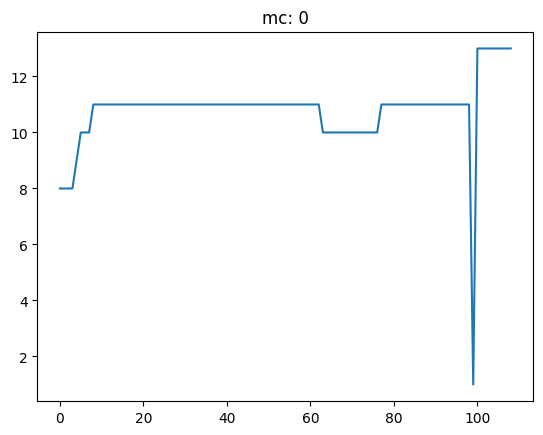

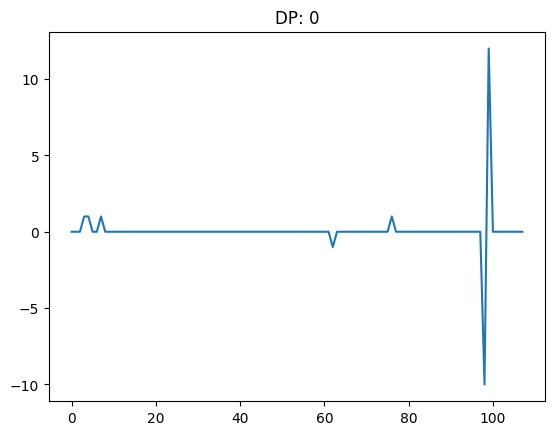

[3, 4, 7, 62, 76, 98, 99]


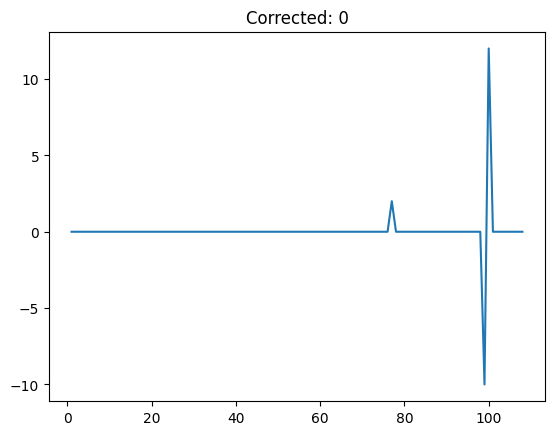

[76, 98, 99]


In [198]:
with open("data/manipulated_output.txt") as file_in:
    seqs = []
    for line in file_in:
        newline = line.rstrip('\n')
        sequence_chars = [char for char in newline]
        #sequence = parse_nucleotides(sequence_chars)
        seqs.append(sequence_chars)

for i in range(len(seqs)):
    # Execute the function we created above on the circular synthetic data.
    # 11110111111011011101010111011011111101111
    # 11111111111101011101010111011011111101111
    # 111111111111111111111111111111111
    # 111111111111101111111111111111111
    xpoints, ypoints, maxcounts, se, pc_diff_profile, artifact, mci = correct_robustly("data/manipulated_output.txt", "11110111111011011101010111011011111101111", i)
    if not (np.array(ypoints) == np.array([0 for i in range(len(ypoints))])).all():
        print(mci)
        print(artifact)
        print([(i, se[i]) for i in range(len(se)) if se[i]!=0])
        # Max Counts
        plt.title("mc: "+str(i))
        plt.plot([i for i in range(len(maxcounts))], maxcounts)
        plt.show()
        # DP
        plt.title("DP: "+str(i))
        plt.plot([i for i in range(len(pc_diff_profile))], pc_diff_profile)
        plt.show()
        print([i for i in range(len(pc_diff_profile)) if pc_diff_profile[i]!=0])
        # Corrected DP
        plt.title("Corrected: "+str(i))
        plt.plot(xpoints, ypoints)
        plt.show()
        print([i for i in range(len(ypoints)) if ypoints[i]!=0])
        break

[0, 0, 0, 0, 4, 5, 5, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32, 32, 33, 34, 35, 36, 37, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 61, 62, 63, 64, 65, 66, 67, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 114, 114, 114]
[[-1, (0, 5), [0, 0, 0, 0, -1]], [-1, (5, 6), [-1]], [-1, (6, 9), [0, 0, -1]], [-1, (9, 22), [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]], [1, (22, 27), [0, 0, 0, 0, 1]], [1, (27, 61), [0, 0, 0, 0, 1, -1, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]], [0, (61, 68), [0, 0, 0, 0, 0, 0, 0]], [0, (68, 101), [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], [-1, (101, 115), [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]]]
[(4, -1), (5, -1), (8, -1), 

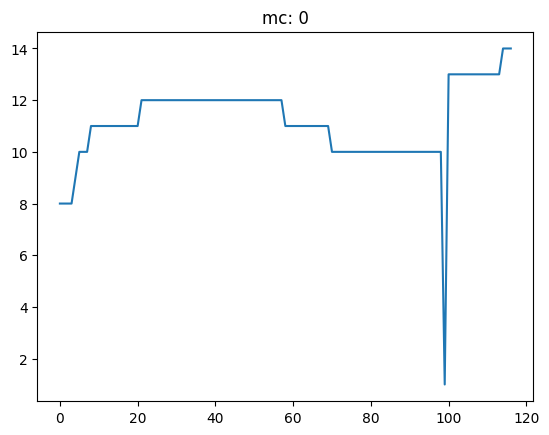

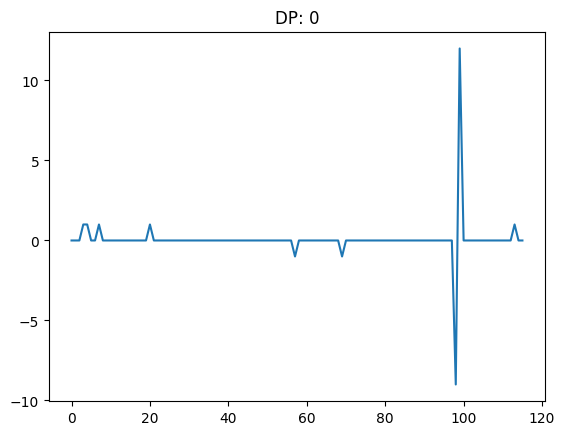

[3, 4, 7, 20, 57, 69, 98, 99, 113]


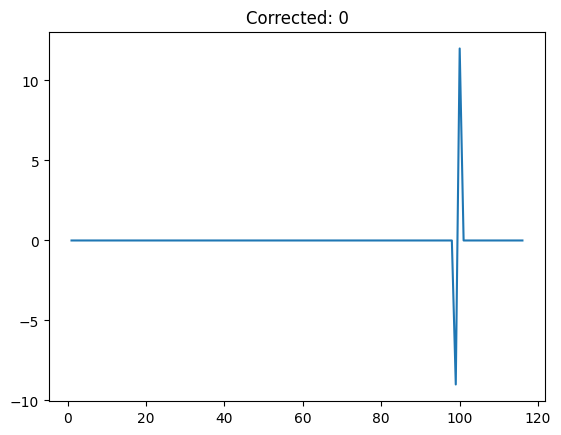

[98, 99]


In [190]:
with open("data/manipulated_output.txt") as file_in:
    seqs = []
    for line in file_in:
        newline = line.rstrip('\n')
        sequence_chars = [char for char in newline]
        #sequence = parse_nucleotides(sequence_chars)
        seqs.append(sequence_chars)

for i in range(len(seqs)):
    # Execute the function we created above on the circular synthetic data.
    # 11110111111011011101010111011011111101111
    # 11111111111101011101010111011011111101111
    # 111111111111111111111111111111111
    # 111111111111101111111111111111111
    xpoints, ypoints, maxcounts, se, pc_diff_profile, artifact, mci = correct_robustly("data/manipulated_output.txt", "111111111111111111111111111111111", i)
    if not (np.array(ypoints) == np.array([0 for i in range(len(ypoints))])).all():
        print(mci)
        print(artifact)
        print([(i, se[i]) for i in range(len(se)) if se[i]!=0])
        # Max Counts
        plt.title("mc: "+str(i))
        plt.plot([i for i in range(len(maxcounts))], maxcounts)
        plt.show()
        # DP
        plt.title("DP: "+str(i))
        plt.plot([i for i in range(len(pc_diff_profile))], pc_diff_profile)
        plt.show()
        print([i for i in range(len(pc_diff_profile)) if pc_diff_profile[i]!=0])
        # Corrected DP
        plt.title("Corrected: "+str(i))
        plt.plot(xpoints, ypoints)
        plt.show()
        print([i for i in range(len(ypoints)) if ypoints[i]!=0])
        break

## Repeat tests

### Simplest repeat data with coverage of 1

[19]


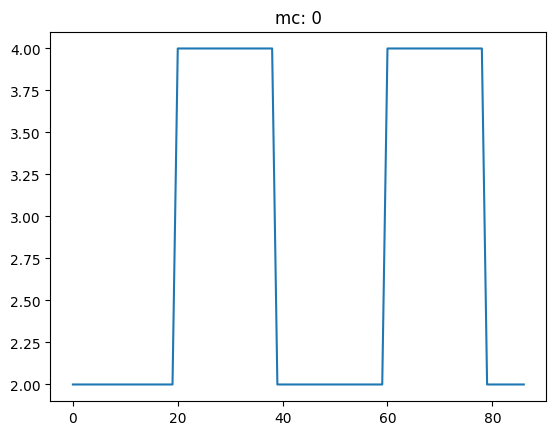

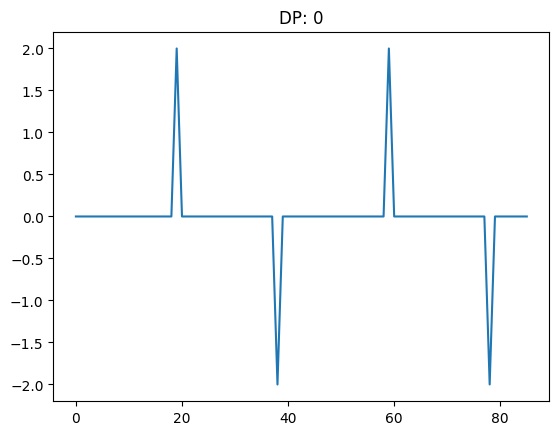

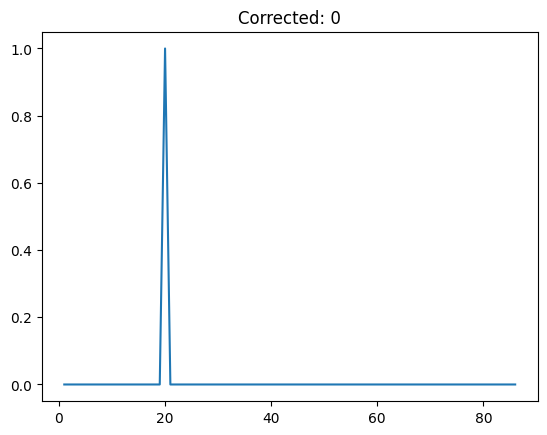

------
mci
[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 2, 3, 4, 5, 6, 9, 20, 20, 20, 20, 20, 20, 21, 20, 20, 20, 20, 20, 20, 21, 22, 23, 24, 25, 26, 27, 40, 40, 40, 40, 40, 40, 41, 40, 40, 40, 40, 40, 40, 41, 42, 43, 44, 45, 46, 59, 60, 60, 60, 60, 60, 60, 61, 60, 60, 60, 60, 60, 60, 61, 62, 63, 64, 65, 66, 67, 80, 80, 80, 80, 80, 80, 81]
artifact
[[-1, (0, 21), [0, 0, 0, 0, 0, 0, 0, 1, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, -2]], [2, (21, 28), [0, 0, 0, 0, 0, 0, 2]], [-2, (28, 61), [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -2]], [2, (61, 68), [0, 0, 0, 0, 0, 0, 2]]]
se points
[0, 0, 0, 0, 0, 0, 0, 1, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, -2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0, 0, 0, 0]
ANOMALIES: 1


In [191]:
with open("data/circular-data.txt") as file_in:
    seqs = []
    for line in file_in:
        newline = line.rstrip('\n')
        sequence_chars = [char for char in newline]
        #sequence = parse_nucleotides(sequence_chars)
        seqs.append(sequence_chars)

#11111101111
#1111011011110111
count_of_anomalies = 0
for i in range(len(seqs)):
    xpoints, ypoints, maxcounts, se, pc_diff_profile, artifact, mci = correct_robustly("data/circular-data.txt", "1111110111111", i)
    if not (np.array(ypoints) == np.array([0 for i in range(len(ypoints))])).all():
        count_of_anomalies += 1
        nonzero_indices = []
        iszero = np.array(ypoints) != np.array([0 for i in range(len(ypoints))])
        for j in range(len(iszero)):
            if iszero[j]:
                nonzero_indices.append(j)
        print(nonzero_indices)
        # Max Counts
        plt.title("mc: "+str(i))
        plt.plot([i for i in range(len(maxcounts))], maxcounts)
        plt.show()
        # DP
        plt.title("DP: "+str(i))
        plt.plot([i for i in range(len(pc_diff_profile))], pc_diff_profile)
        plt.savefig('imgs/circular_long_dp.png', bbox_inches='tight')
        plt.show()
        #print([i for i in range(len(pc_diff_profile)) if pc_diff_profile[i]!=0])
        # Corrected DP
        plt.title("Corrected: "+str(i))
        plt.plot(xpoints, ypoints)
        plt.savefig('imgs/circular_long_cdp.png', bbox_inches='tight')
        plt.show()
        #print([i for i in range(len(ypoints)) if ypoints[i]!=0])
        print("------")
        print("mci")
        print(mci)
        print("artifact")
        print(artifact)
        print("se points")
        print(se)
        break
print("ANOMALIES: " + str(count_of_anomalies))

### Synthetic data from repeat genome with more but still evenly spaced reads

------


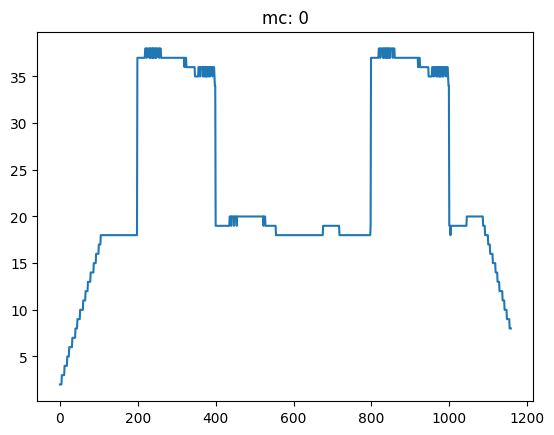

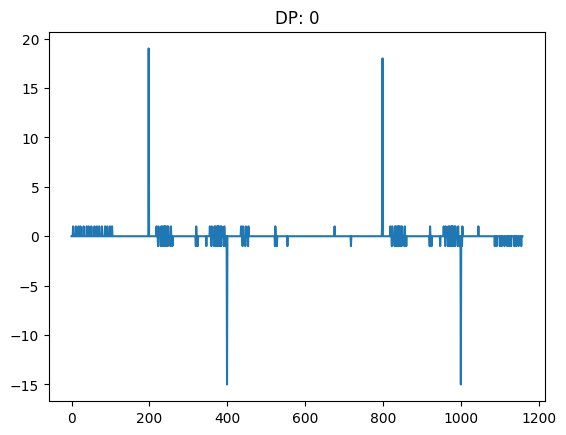

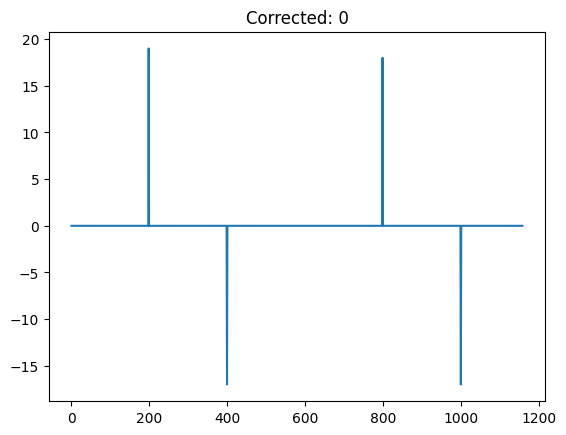

------
ANOMALIES: 1


In [192]:
count_of_anomalies = 0
for i in range(30):
    xpoints, ypoints, maxcounts, se, pc_diff_profile, artifact, mci = correct_robustly("data/longcirc_reads_even.txt", "11110111111011011101010111011011111101111", i)
    if not (np.array(ypoints) == np.array([0 for i in range(len(ypoints))])).all():
        count_of_anomalies += 1
        print("------")
        #print(mci)
        #print(artifact)
        #print(se)
        nonzero_indices = []
        iszero = np.array(ypoints) != np.array([0 for i in range(len(ypoints))])
        for j in range(len(iszero)):
            if iszero[j]:
                nonzero_indices.append(j)
        #print(nonzero_indices)
        # Max Counts
        plt.title("mc: "+str(i))
        plt.plot([i for i in range(len(maxcounts))], maxcounts)
        plt.show()
        # DP
        plt.title("DP: "+str(i))
        plt.plot([i for i in range(len(pc_diff_profile))], pc_diff_profile)
        plt.savefig('imgs/circular_long_dp.png', bbox_inches='tight')
        plt.show()
        #print([i for i in range(len(pc_diff_profile)) if pc_diff_profile[i]!=0])
        # Corrected DP
        plt.title("Corrected: "+str(i))
        plt.plot(xpoints, ypoints)
        plt.savefig('imgs/circular_long_cdp.png', bbox_inches='tight')
        plt.show()
        #print([i for i in range(len(ypoints)) if ypoints[i]!=0])
        print("------")
        break
print("ANOMALIES: " + str(count_of_anomalies))

#### Now with solid k-mer

------


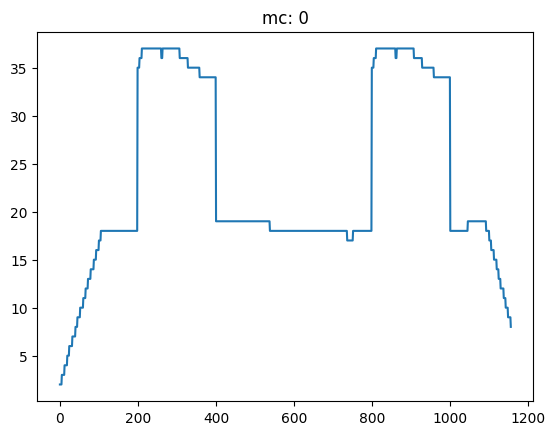

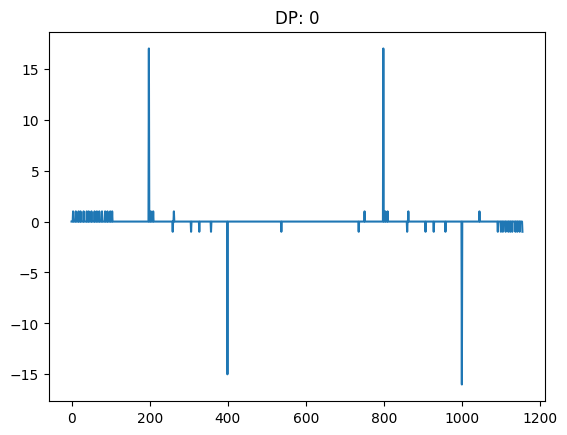

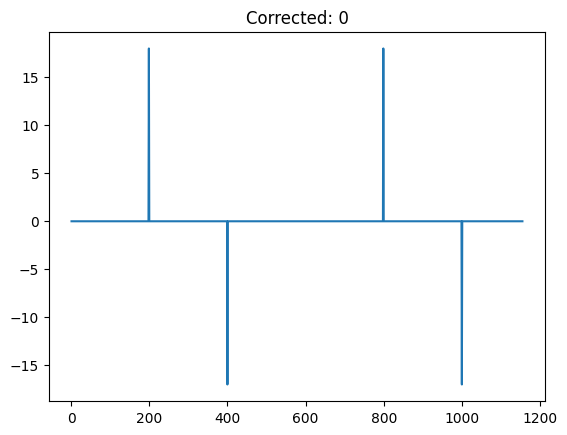

------
ANOMALIES: 1


In [193]:
count_of_anomalies = 0
for i in range(30):
    xpoints, ypoints, maxcounts, se, pc_diff_profile, artifact, mci = correct_robustly("data/longcirc_reads_even.txt", "11111111111111111111111111111111111111111111", i)
    if not (np.array(ypoints) == np.array([0 for i in range(len(ypoints))])).all():
        count_of_anomalies += 1
        print("------")
        #print(mci)
        #print(artifact)
        #print(se)
        nonzero_indices = []
        iszero = np.array(ypoints) != np.array([0 for i in range(len(ypoints))])
        for j in range(len(iszero)):
            if iszero[j]:
                nonzero_indices.append(j)
        #print(nonzero_indices)
        # Max Counts
        plt.title("mc: "+str(i))
        plt.plot([i for i in range(len(maxcounts))], maxcounts)
        plt.show()
        # DP
        plt.title("DP: "+str(i))
        plt.plot([i for i in range(len(pc_diff_profile))], pc_diff_profile)
        #plt.savefig('imgs/circular_long_dp.png', bbox_inches='tight')
        plt.show()
        #print([i for i in range(len(pc_diff_profile)) if pc_diff_profile[i]!=0])
        # Corrected DP
        plt.title("Corrected: "+str(i))
        plt.plot(xpoints, ypoints)
        #plt.savefig('imgs/circular_long_cdp.png', bbox_inches='tight')
        plt.show()
        #print([i for i in range(len(ypoints)) if ypoints[i]!=0])
        print("------")
        break
print("ANOMALIES: " + str(count_of_anomalies))

### Synthetic data from repeat genome with random starts

------


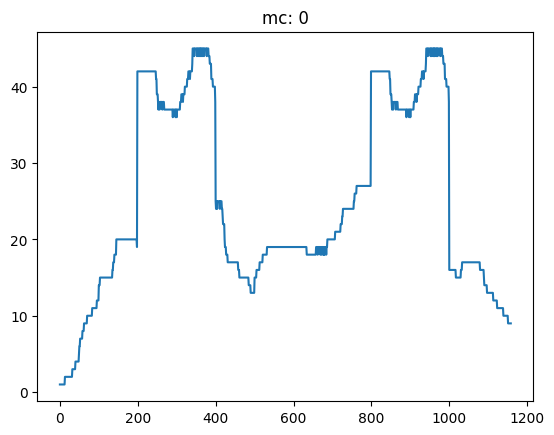

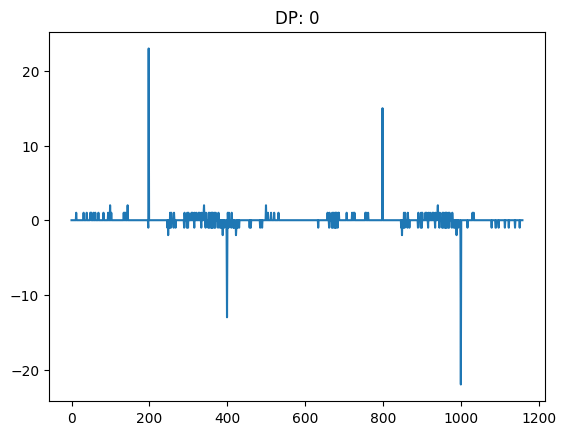

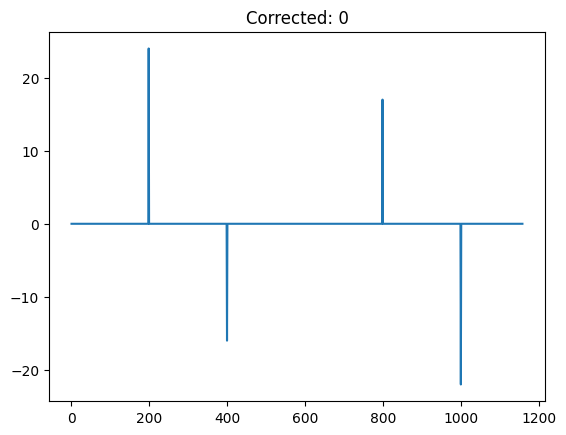

------
ANOMALIES: 1


In [194]:
count_of_anomalies = 0
for i in range(30):
    xpoints, ypoints, maxcounts, se, pc_diff_profile, artifact, mci = correct_robustly("data/longcirc_reads_random.txt", "11110111111011011101010111011011111101111", i)
    if not (np.array(ypoints) == np.array([0 for i in range(len(ypoints))])).all():
        count_of_anomalies += 1
        print("------")
        #print(mci)
        #print(artifact)
        #print(se)
        nonzero_indices = []
        iszero = np.array(ypoints) != np.array([0 for i in range(len(ypoints))])
        for j in range(len(iszero)):
            if iszero[j]:
                nonzero_indices.append(j)
        #print(nonzero_indices)
        # Max Counts
        plt.title("mc: "+str(i))
        plt.plot([i for i in range(len(maxcounts))], maxcounts)
        plt.show()
        # DP
        plt.title("DP: "+str(i))
        plt.plot([i for i in range(len(pc_diff_profile))], pc_diff_profile)
        #plt.savefig('imgs/circular_long_dp.png', bbox_inches='tight')
        plt.show()
        #print([i for i in range(len(pc_diff_profile)) if pc_diff_profile[i]!=0])
        # Corrected DP
        plt.title("Corrected: "+str(i))
        plt.plot(xpoints, ypoints)
        #plt.savefig('imgs/circular_long_cdp.png', bbox_inches='tight')
        plt.show()
        #print([i for i in range(len(ypoints)) if ypoints[i]!=0])
        print("------")
        break
print("ANOMALIES: " + str(count_of_anomalies))

#### Now with solid k-mer

------


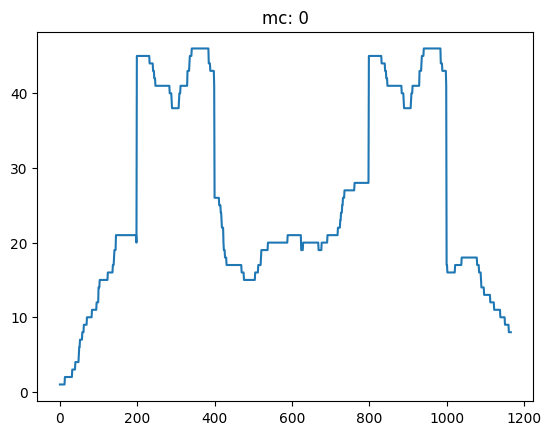

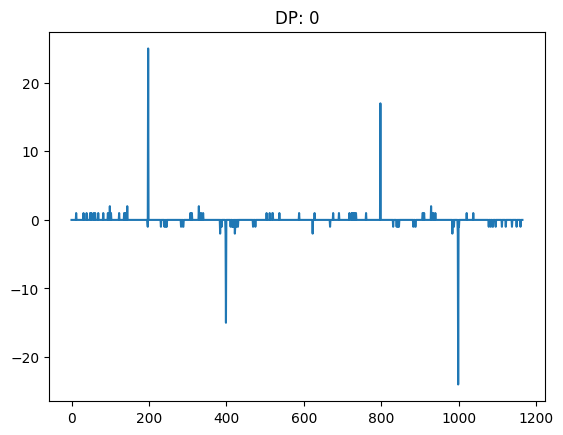

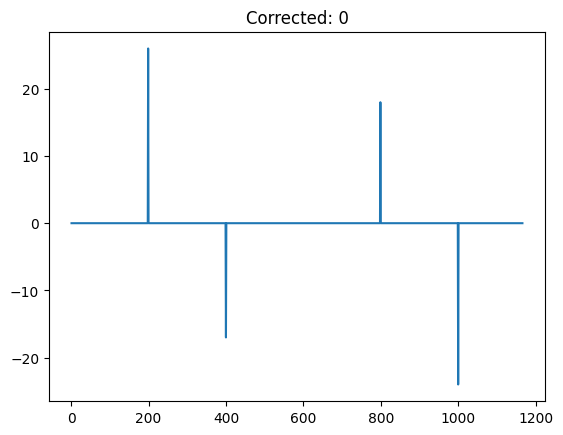

------
ANOMALIES: 1


In [195]:
count_of_anomalies = 0
for i in range(30):
    xpoints, ypoints, maxcounts, se, pc_diff_profile, artifact, mci = correct_robustly("data/longcirc_reads_random.txt", "111111111111111111111111111111111", i)
    if not (np.array(ypoints) == np.array([0 for i in range(len(ypoints))])).all():
        count_of_anomalies += 1
        print("------")
        #print(mci)
        #print(artifact)
        #print(se)
        nonzero_indices = []
        iszero = np.array(ypoints) != np.array([0 for i in range(len(ypoints))])
        for j in range(len(iszero)):
            if iszero[j]:
                nonzero_indices.append(j)
        #print(nonzero_indices)
        # Max Counts
        plt.title("mc: "+str(i))
        plt.plot([i for i in range(len(maxcounts))], maxcounts)
        plt.show()
        # DP
        plt.title("DP: "+str(i))
        plt.plot([i for i in range(len(pc_diff_profile))], pc_diff_profile)
        #plt.savefig('imgs/circular_long_dp.png', bbox_inches='tight')
        plt.show()
        #print([i for i in range(len(pc_diff_profile)) if pc_diff_profile[i]!=0])
        # Corrected DP
        plt.title("Corrected: "+str(i))
        plt.plot(xpoints, ypoints)
        #plt.savefig('imgs/circular_long_cdp.png', bbox_inches='tight')
        plt.show()
        #print([i for i in range(len(ypoints)) if ypoints[i]!=0])
        print("------")
        break
print("ANOMALIES: " + str(count_of_anomalies))

## Very short circular data

[28, 60, 88, 120]


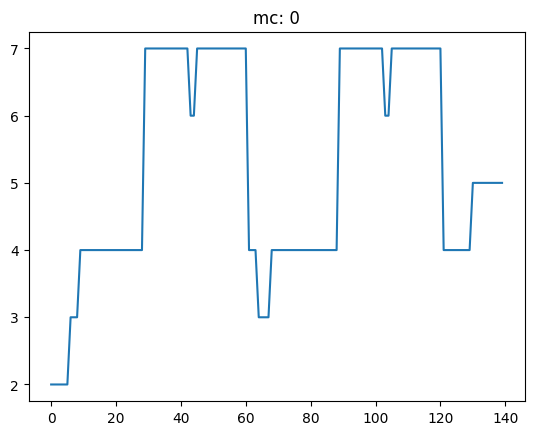

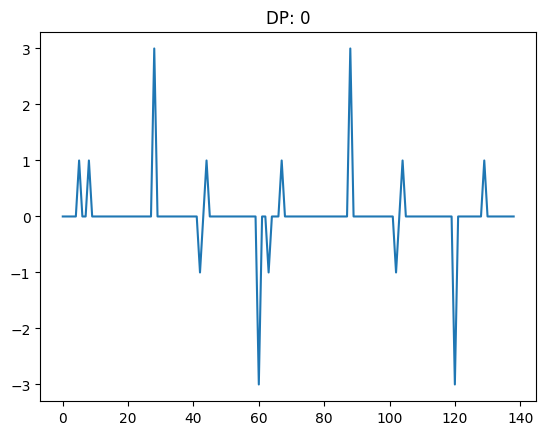

[5, 8, 28, 42, 44, 60, 63, 67, 88, 102, 104, 120, 129]


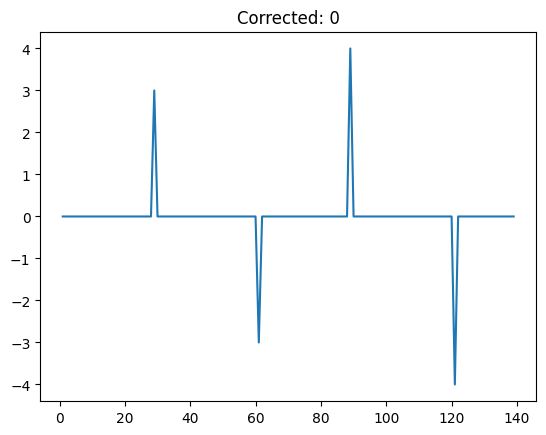

[28, 60, 88, 120]
------
mci
[0, 0, 0, 0, 0, 0, 6, 6, 6, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 15, 15, 15, 15, 15, 15, 24, 24, 24, 24, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 33, 33, 33, 33, 34, 35, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 46, 49, 49, 49, 50, 51, 54, 54, 54, 55, 56, 57, 58, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 72, 72, 72, 72, 73, 75, 75, 76, 77, 81, 81, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 93, 93, 93, 93, 94, 95, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 106, 109, 109, 109, 110, 111, 113, 113, 122, 122, 122, 122, 122, 122, 122, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130]
artifact
[[-1, (0, 7), [0, 0, 0, 0, 0, 0, -1]], [-1, (7, 10), [0, 0, -1]], [0, (10, 30), [1, 0, 0, 0, 0, -1, 1, 0, 0, 1, -1, 0, 0, 0, -1, 1, 0, -1, 0, 0]], [1, (30, 35), [1, 1, -1, -1, 1]], [-1, (35, 46), [0, 0, 1, -1, 0, 0, 0, 0, 1, -1, -1]], [0, (46, 55), [0, 1, 1, -2, 0, 0, 1, 0, -1]], [1, (55, 56), [1]], [-1, (56, 69), [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]], [1, (69, 90), [1, 0, 0, -1

In [196]:
with open("data/shortcirc_reads_random.txt") as file_in:
    seqs = []
    for line in file_in:
        newline = line.rstrip('\n')
        sequence_chars = [char for char in newline]
        #sequence = parse_nucleotides(sequence_chars)
        seqs.append(sequence_chars)

#11111101111
#1111011011110111
count_of_anomalies = 0
for i in range(len(seqs)):
    xpoints, ypoints, maxcounts, se, pc_diff_profile, artifact, mci = correct_robustly("data/shortcirc_reads_random.txt", "1111111111", i)
    if not (np.array(ypoints) == np.array([0 for i in range(len(ypoints))])).all():
        count_of_anomalies += 1
        nonzero_indices = []
        iszero = np.array(ypoints) != np.array([0 for i in range(len(ypoints))])
        for j in range(len(iszero)):
            if iszero[j]:
                nonzero_indices.append(j)
        print(nonzero_indices)
        # Max Counts
        plt.title("mc: "+str(i))
        plt.plot([i for i in range(len(maxcounts))], maxcounts)
        plt.show()
        # DP
        plt.title("DP: "+str(i))
        plt.plot([i for i in range(len(pc_diff_profile))], pc_diff_profile)
        plt.show()
        print([i for i in range(len(pc_diff_profile)) if pc_diff_profile[i]!=0])
        # Corrected DP
        plt.title("Corrected: "+str(i))
        plt.plot(xpoints, ypoints)
        plt.show()
        print([i for i in range(len(ypoints)) if ypoints[i]!=0])
        print("------")
        print("mci")
        print(mci)
        print("artifact")
        print(artifact)
        print("se points")
        print([(i, se[i]) for i in range(len(se)) if se[i] != 0])
        break
print("ANOMALIES: " + str(count_of_anomalies))